# Reconstrucción del campo de flujo en una cavidad cuadrada
## TP N°2: Modelado PINN
### Redes Neuronales Informadas por Física - Maestria en Inteligencia Artificial
#### Grupo N°4: Jorge Ceferino Valdez, Fabian Sarmiento y Trinidad Monreal.
---

Buscamos reconstruir el campo de flujo estacionario en una cavidad cuadrada usando una Red Neuronal Informada por Física (PINN). Se trata de resolver las ecuaciones de Navier-Stokes incomprensibles:

$$(\mathbf{u} \cdot \nabla)\mathbf{u} = -\nabla p + \frac{1}{Re} \nabla^2 \mathbf{u} \text{,  en Ω}$$

$$\nabla \cdot \mathbf{u} = 0 \text{,  en Ω}$$

con las siguientes condiciones de borde:

- _No-slip_ en las fronteras laterales e inferior ($\mathbf{u} = (0,0)$)
- Velocidad constante en direccion $+x$ en la frontera superior ($\mathbf{u} = (1,0)$)

y $Ω = [0,1]⊗[0,1]$

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from scipy.io import loadmat

from IPython.display import clear_output
import time
from datetime import datetime, timedelta
import gc

np.random.seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    device_name = "CUDA GPU"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU (MPS)"
else:
    device = torch.device("cpu")
    device_name = "CPU"

# Configurar semillas para reproducibilidad
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
elif torch.backends.mps.is_available():
    # MPS usa la misma semilla que PyTorch general
    torch.manual_seed(42)

print(f"Usando dispositivo: {device} ({device_name})")


Usando dispositivo: mps (Apple Silicon GPU (MPS))


### Clase PINN Navier-stokes

In [2]:
class PINN_Module(nn.Module):
    """
    Red Neuronal Informada por Física para resolver las ecuaciones de Navier-Stokes
    en una cavidad cuadrada con lid-driven flow
    """
    
    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Device = model_parameters["Device"]
        self.LowerBounds = model_parameters["LowerBounds"]
        self.UpperBounds = model_parameters["UpperBounds"]
        self.Re = model_parameters["Re"]
        self.InputDimensions = model_parameters["InputDimensions"]
        self.OutputDimensions = model_parameters["OutputDimensions"]
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"]
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"]
        self.ActivationFunction = model_parameters["ActivationFunction"]
        
        # Definir arquitectura de la red
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) 
             for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)
        
        # Inicialización Xavier
        self.init_xavier()

    def forward(self, X):
        """
        Forward pass de la red neuronal
        Input: X tensor de forma (N, 2) con coordenadas (x, y)
        Output: tensor de forma (N, 3) con (u, v, p)
        """
        lb = self.LowerBounds
        ub = self.UpperBounds
        
        # Normalización de entradas a [-1, 1]
        X = 2 * (X - lb) / (ub - lb) - 1
        
        # Forward pass
        output = self.ActivationFunction(self.InputLayer(X))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        
        return output

    def init_xavier(self):
        """Inicialización Xavier mejorada de los pesos"""
        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # Bias no cero para romper simetría
                torch.nn.init.uniform_(m.bias, -0.1, 0.1)
        
        self.apply(init_weights)

    def navierstokesResidue(self, X, uvp):
        """
        Calcula los residuos de las ecuaciones de Navier-Stokes
        
        Ecuaciones:
        (u·∇)u = -∇p + (1/Re)∇²u  →  u*∂u/∂x + v*∂u/∂y + ∂p/∂x - (1/Re)(∂²u/∂x² + ∂²u/∂y²) = 0
        (u·∇)v = -∇p + (1/Re)∇²v  →  u*∂v/∂x + v*∂v/∂y + ∂p/∂y - (1/Re)(∂²v/∂x² + ∂²v/∂y²) = 0
        ∇·u = ∂u/∂x + ∂v/∂y = 0
        """
        u = uvp[:, 0:1]  # velocidad en x
        v = uvp[:, 1:2]  # velocidad en y
        p = uvp[:, 2:3]  # presión
        
        Re = self.Re
        
        # Derivadas de primer orden usando autodiferenciación
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        u_x = diff_u[:, 0:1]
        u_y = diff_u[:, 1:2]
        
        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        v_x = diff_v[:, 0:1]
        v_y = diff_v[:, 1:2]
        
        diff_p = torch.autograd.grad(p, X, create_graph=True, grad_outputs=torch.ones_like(p))[0]
        p_x = diff_p[:, 0:1]
        p_y = diff_p[:, 1:2]
        
        # Derivadas de segundo orden
        u_xx = torch.autograd.grad(u_x, X, create_graph=True, grad_outputs=torch.ones_like(u_x))[0][:, 0:1]
        u_yy = torch.autograd.grad(u_y, X, create_graph=True, grad_outputs=torch.ones_like(u_y))[0][:, 1:2]
        
        v_xx = torch.autograd.grad(v_x, X, create_graph=True, grad_outputs=torch.ones_like(v_x))[0][:, 0:1]
        v_yy = torch.autograd.grad(v_y, X, create_graph=True, grad_outputs=torch.ones_like(v_y))[0][:, 1:2]
        
        # Residuos de las ecuaciones de momentum
        residue_u = u * u_x + v * u_y + p_x - (1/Re) * (u_xx + u_yy)
        residue_v = u * v_x + v * v_y + p_y - (1/Re) * (v_xx + v_yy)
        
        # Residuo de continuidad
        residue_continuity = u_x + v_y
        
        return residue_u, residue_v, residue_continuity

In [ ]:
# Parámetros del problema
Re = 100.0  # Número de Reynolds
xi, xf = 0.0, 1.0  # Límites en x
yi, yf = 0.0, 1.0  # Límites en y

# Límites del dominio
lb = torch.tensor([xi, yi], device=device)  # Lower bounds
ub = torch.tensor([xf, yf], device=device)  # Upper bounds

# Condiciones de borde
u_wall = 0.0    # Velocidad en las paredes (no-slip)
v_wall = 0.0    # Velocidad normal en las paredes
u_lid = 1.0     # Velocidad de la tapa superior
v_lid = 0.0     # Velocidad normal en la tapa

print(f"Número de Reynolds: {Re}")
print(f"Dominio: [{xi}, {xf}] x [{yi}, {yf}]")
print(f"Condiciones de borde:")
print(f"  - Paredes laterales e inferior: u=v=0 (no-slip)")
print(f"  - Tapa superior: u={u_lid}, v={v_lid}")

Número de Reynolds: 100.0
Dominio: [0.0, 1.0] x [0.0, 1.0]
Condiciones de borde:
  - Paredes laterales e inferior: u=v=0 (no-slip)
  - Tapa superior: u=1.0, v=0.0


#### Carga de datos Ground-truth

In [4]:
# Cargar archivos
pressure_mat = loadmat('Re-100/pressure.mat')
velocity_mat = loadmat('Re-100/velocity.mat')

# Extraer arrays
p_array = pressure_mat['p']
u_array = velocity_mat['u']
v_array = velocity_mat['v']

# Convertir a tensores
p_tensor = torch.tensor(p_array, dtype=torch.float32, device=device)
u_tensor = torch.tensor(u_array, dtype=torch.float32, device=device)
v_tensor = torch.tensor(v_array, dtype=torch.float32, device=device)

ny, nx = p_tensor.shape
print(f"Malla de referencia: {nx} x {ny}")

# Crear grilla de puntos de referencia
x_ref = torch.linspace(xi, xf, nx, device=device)
y_ref = torch.linspace(yi, yf, ny, device=device)
Xg_ref, Yg_ref = torch.meshgrid(x_ref, y_ref, indexing='ij')
X_ref = torch.stack([Xg_ref.reshape(-1), Yg_ref.reshape(-1)], dim=1)

Malla de referencia: 20201 x 1


### Generación de puntos de colocación según TP2.

In [5]:
# Parámetros de muestreo según TP N°2
N_pde = 10000  # Puntos para residuos de PDE
N_bc = 1000    # Puntos para condiciones de borde

print(f"Generando puntos de colocación:")
print(f"  - N_pde = {N_pde}")
print(f"  - N_bc = {N_bc}")

# Puntos PDE (interior del dominio) - muestreo aleatorio
x_pde = torch.rand(N_pde, device=device)
y_pde = torch.rand(N_pde, device=device)
pde_points = torch.stack([x_pde, y_pde], dim=1)

# Puntos de condiciones de borde
N_each = N_bc // 4  # 250 puntos por cada borde

# Borde inferior (y = 0)
x_bottom = torch.rand(N_each, device=device)
y_bottom = torch.zeros(N_each, device=device)
bottom = torch.stack([x_bottom, y_bottom], dim=1)

# Borde superior (y = 1)
x_top = torch.rand(N_each, device=device)
y_top = torch.ones(N_each, device=device)
top = torch.stack([x_top, y_top], dim=1)

# Borde izquierdo (x = 0)
x_left = torch.zeros(N_each, device=device)
y_left = torch.rand(N_each, device=device)
left = torch.stack([x_left, y_left], dim=1)

# Borde derecho (x = 1)
x_right = torch.ones(N_each, device=device)
y_right = torch.rand(N_each, device=device)
right = torch.stack([x_right, y_right], dim=1)

# Combinar todos los puntos de frontera (solo para referencia)
bc_points = torch.cat([bottom, top, left, right], dim=0)

print("Puntos de colocación generados exitosamente")

Generando puntos de colocación:
  - N_pde = 10000
  - N_bc = 1000
Puntos de colocación generados exitosamente


### Configuración del modelo

In [6]:
# # Parámetros del modelo
# model_parameters = {
#     "Device": device,
#     "LowerBounds": lb.to(device),
#     "UpperBounds": ub.to(device),
#     "Re": Re,
#     "InputDimensions": 2,      # (x, y)
#     "OutputDimensions": 3,     # (u, v, p)
#     "NumberOfNeurons": 50,     # Neuronas por capa oculta
#     "NumberOfHiddenLayers": 8, # Capas ocultas
#     "ActivationFunction": nn.Tanh()
# }

In [7]:
# model_parameters = {
#     "Device": device,
#     "LowerBounds": lb.to(device),
#     "UpperBounds": ub.to(device),
#     "Re": Re,
#     "InputDimensions": 2,
#     "OutputDimensions": 3,
#     "NumberOfNeurons": 150,        # Era 50 → TRIPLICADO
#     "NumberOfHiddenLayers": 10,    # Era 8 → AUMENTADO
#     "ActivationFunction": nn.Tanh()
# }

In [8]:
# Parámetros del modelo
model_parameters = {
    "Device": device,
    "LowerBounds": lb.to(device),
    "UpperBounds": ub.to(device),
    "Re": Re,
    "InputDimensions": 2,      # (x, y)
    "OutputDimensions": 3,     # (u, v, p)
    "NumberOfNeurons": 200,    # Era 150 - AUMENTADO para más capacidad
    "NumberOfHiddenLayers": 12, # Era 10 - AUMENTADO para capturar vórtices complejos
    "ActivationFunction": nn.Tanh()
}

In [9]:
# Crear modelo
torch.manual_seed(10)
model = PINN_Module(model_parameters).to(device)

print("Arquitectura del modelo:")
print(f"  - Entradas: {model_parameters['InputDimensions']} (x, y)")
print(f"  - Salidas: {model_parameters['OutputDimensions']} (u, v, p)")
print(f"  - Capas ocultas: {model_parameters['NumberOfHiddenLayers']}")
print(f"  - Neuronas por capa: {model_parameters['NumberOfNeurons']}")
print(f"  - Función de activación: {model_parameters['ActivationFunction']}")

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  - Total de parámetros entrenables: {total_params}")

Arquitectura del modelo:
  - Entradas: 2 (x, y)
  - Salidas: 3 (u, v, p)
  - Capas ocultas: 12
  - Neuronas por capa: 200
  - Función de activación: Tanh()
  - Total de parámetros entrenables: 443403


### Entrenamiento

In [10]:
# Configuración del entrenamiento
epochs = 12000  # Era 8000 - AUMENTADO para convergencia con nuevos pesos
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Learning rate inicial más alto
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9995)  # Decay gradual

# ESQUEMA DE PESOS PROGRESIVO - Empezar con BC fuerte, luego balancear
initial_weight_bc = 5000.0   # Inicio: BC dominante
final_weight_bc = 1000.0     # Final: BC balanceado  
weight_pde = 100.0           # PDE constante pero significativo

# Listas para almacenar la evolución de las pérdidas
loss_train = []
loss_train_momentum_u = []
loss_train_momentum_v = []
loss_train_continuity = []
loss_train_bc = []

print("Iniciando entrenamiento ...")
print(f"Épocas: {epochs}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Optimizador: {type(optimizer).__name__}")
print(f"Pesos progresivos - PDE: {weight_pde}, BC: {initial_weight_bc} → {final_weight_bc}")
print(f"CONDICIONES DE BORDE SEPARADAS para mejor imposición")
print(f"Arquitectura MAXIMIZADA: {model_parameters['NumberOfHiddenLayers']} capas x {model_parameters['NumberOfNeurons']} neuronas")
print(f"Puntos PDE: {N_pde}")

t0 = datetime.now()

for epoch in range(epochs):
    # PESO PROGRESIVO: BC fuerte al inicio, balanceado al final
    progress = epoch / epochs
    current_weight_bc = initial_weight_bc * (1 - progress) + final_weight_bc * progress
    
    optimizer.zero_grad()
    
    # === RESIDUOS DE PDE ===
    pde_points.requires_grad = True
    uvp_pde = model(pde_points)
    
    # Calcular residuos
    residue_u, residue_v, residue_continuity = model.navierstokesResidue(pde_points, uvp_pde)
    
    # Pérdidas PDE (los residuos deben ser cero)
    loss_momentum_u = loss_fn(residue_u, torch.zeros_like(residue_u))
    loss_momentum_v = loss_fn(residue_v, torch.zeros_like(residue_v))
    loss_continuity = loss_fn(residue_continuity, torch.zeros_like(residue_continuity))
    
    # === CONDICIONES DE BORDE - SEPARADAS ===
    # Borde superior (lid-driven): u = 1, v = 0
    uvp_top = model(top)
    loss_bc_top_u = loss_fn(uvp_top[:, 0:1], torch.ones_like(uvp_top[:, 0:1]))
    loss_bc_top_v = loss_fn(uvp_top[:, 1:2], torch.zeros_like(uvp_top[:, 1:2]))
    
    # Borde inferior (no-slip): u = 0, v = 0
    uvp_bottom = model(bottom)
    loss_bc_bottom_u = loss_fn(uvp_bottom[:, 0:1], torch.zeros_like(uvp_bottom[:, 0:1]))
    loss_bc_bottom_v = loss_fn(uvp_bottom[:, 1:2], torch.zeros_like(uvp_bottom[:, 1:2]))
    
    # Borde izquierdo (no-slip): u = 0, v = 0
    uvp_left = model(left)
    loss_bc_left_u = loss_fn(uvp_left[:, 0:1], torch.zeros_like(uvp_left[:, 0:1]))
    loss_bc_left_v = loss_fn(uvp_left[:, 1:2], torch.zeros_like(uvp_left[:, 1:2]))
    
    # Borde derecho (no-slip): u = 0, v = 0
    uvp_right = model(right)
    loss_bc_right_u = loss_fn(uvp_right[:, 0:1], torch.zeros_like(uvp_right[:, 0:1]))
    loss_bc_right_v = loss_fn(uvp_right[:, 1:2], torch.zeros_like(uvp_right[:, 1:2]))
    
    # === PÉRDIDA TOTAL ===
    loss_pde_total = loss_momentum_u + loss_momentum_v + loss_continuity
    loss_bc_total = (loss_bc_top_u + loss_bc_top_v + loss_bc_bottom_u + loss_bc_bottom_v + 
                     loss_bc_left_u + loss_bc_left_v + loss_bc_right_u + loss_bc_right_v)
    loss_total = weight_pde * loss_pde_total + current_weight_bc * loss_bc_total
    
    # Backpropagation
    loss_total.backward()
    optimizer.step()
    scheduler.step()  # Learning rate scheduling
    
    # Almacenar pérdidas
    loss_train.append(loss_total.item())
    loss_train_momentum_u.append(loss_momentum_u.item())
    loss_train_momentum_v.append(loss_momentum_v.item())
    loss_train_continuity.append(loss_continuity.item())
    loss_train_bc.append(loss_bc_total.item())
    
    # Imprimir progreso
    if epoch % 500 == 0 or epoch == epochs - 1:
        optimizer_str = type(optimizer).__name__
        # Verificar condición lid-driven durante entrenamiento
        with torch.no_grad():
            u_top_check = model(top)[:, 0].mean().item()
        print(f"##TRAIN## {optimizer_str} - Epoch: {epoch:4d}, "
              f"Overall: {loss_total.item():.5e}, "
              f"PDE: {loss_pde_total.item():.5e}, "
              f"BC: {loss_bc_total.item():.5e}, "
              f"u_top: {u_top_check:.4f}, "
              f"w_bc: {current_weight_bc:.0f}, "
              f"lr: {optimizer.param_groups[0]['lr']:.2e}")

elapsed_time_train = datetime.now() - t0
print(f"\nTiempo de entrenamiento: {elapsed_time_train.total_seconds():.2f} segundos")


Iniciando entrenamiento ...
Épocas: 12000
Learning rate: 0.001
Optimizador: Adam
Pesos progresivos - PDE: 100.0, BC: 5000.0 → 1000.0
CONDICIONES DE BORDE SEPARADAS para mejor imposición
Arquitectura MAXIMIZADA: 12 capas x 200 neuronas
Puntos PDE: 10000
##TRAIN## Adam - Epoch:    0, Overall: 7.97092e+04, PDE: 2.71719e+02, BC: 1.05075e+01, u_top: -2.8947, w_bc: 5000, lr: 1.00e-03
##TRAIN## Adam - Epoch:  500, Overall: 1.85979e+02, PDE: 4.46147e-01, BC: 2.92479e-02, u_top: 1.0732, w_bc: 4833, lr: 7.78e-04
##TRAIN## Adam - Epoch: 1000, Overall: 6.19861e+01, PDE: 1.26662e-01, BC: 1.05686e-02, u_top: 0.9866, w_bc: 4667, lr: 6.06e-04
##TRAIN## Adam - Epoch: 1500, Overall: 5.20264e+01, PDE: 9.67689e-02, BC: 9.41101e-03, u_top: 0.9732, w_bc: 4500, lr: 4.72e-04
##TRAIN## Adam - Epoch: 2000, Overall: 4.53687e+01, PDE: 6.08085e-02, BC: 9.06642e-03, u_top: 1.0107, w_bc: 4333, lr: 3.68e-04
##TRAIN## Adam - Epoch: 2500, Overall: 3.87267e+01, PDE: 5.79549e-02, BC: 7.90349e-03, u_top: 0.9655, w_bc: 416

In [11]:
# Verificación final de condiciones de borde
print("\n=== VERIFICACIÓN FINAL DE CONDICIONES DE BORDE ===")
with torch.no_grad():
    # Verificar condición lid-driven
    uvp_top_final = model(top)
    u_top_mean = uvp_top_final[:, 0].mean().item()
    u_top_std = uvp_top_final[:, 0].std().item()
    v_top_mean = uvp_top_final[:, 1].mean().item()
    
    # Verificar condiciones no-slip
    uvp_bottom_final = model(bottom)
    u_bottom_mean = uvp_bottom_final[:, 0].mean().item()
    v_bottom_mean = uvp_bottom_final[:, 1].mean().item()
    
    print(f"Borde superior (lid-driven):")
    print(f"  u: {u_top_mean:.6f} ± {u_top_std:.6f} (objetivo: 1.0)")
    print(f"  v: {v_top_mean:.6f} (objetivo: 0.0)")
    print(f"Borde inferior (no-slip):")
    print(f"  u: {u_bottom_mean:.6f} (objetivo: 0.0)")
    print(f"  v: {v_bottom_mean:.6f} (objetivo: 0.0)")
    
    # Status de convergencia de BC
    if abs(u_top_mean - 1.0) < 0.1:
        print("✓ Condición lid-driven SATISFECHA")
    else:
        print("⚠ Condición lid-driven NO satisfecha")
    
    if abs(u_bottom_mean) < 0.05 and abs(v_bottom_mean) < 0.05:
        print("✓ Condición no-slip SATISFECHA")  
    else:
        print("⚠ Condición no-slip NO satisfecha")



=== VERIFICACIÓN FINAL DE CONDICIONES DE BORDE ===
Borde superior (lid-driven):
  u: 0.996562 ± 0.027815 (objetivo: 1.0)
  v: 0.000010 (objetivo: 0.0)
Borde inferior (no-slip):
  u: 0.000040 (objetivo: 0.0)
  v: 0.000151 (objetivo: 0.0)
✓ Condición lid-driven SATISFECHA
✓ Condición no-slip SATISFECHA


### Gráficos de evolución de pérdidas

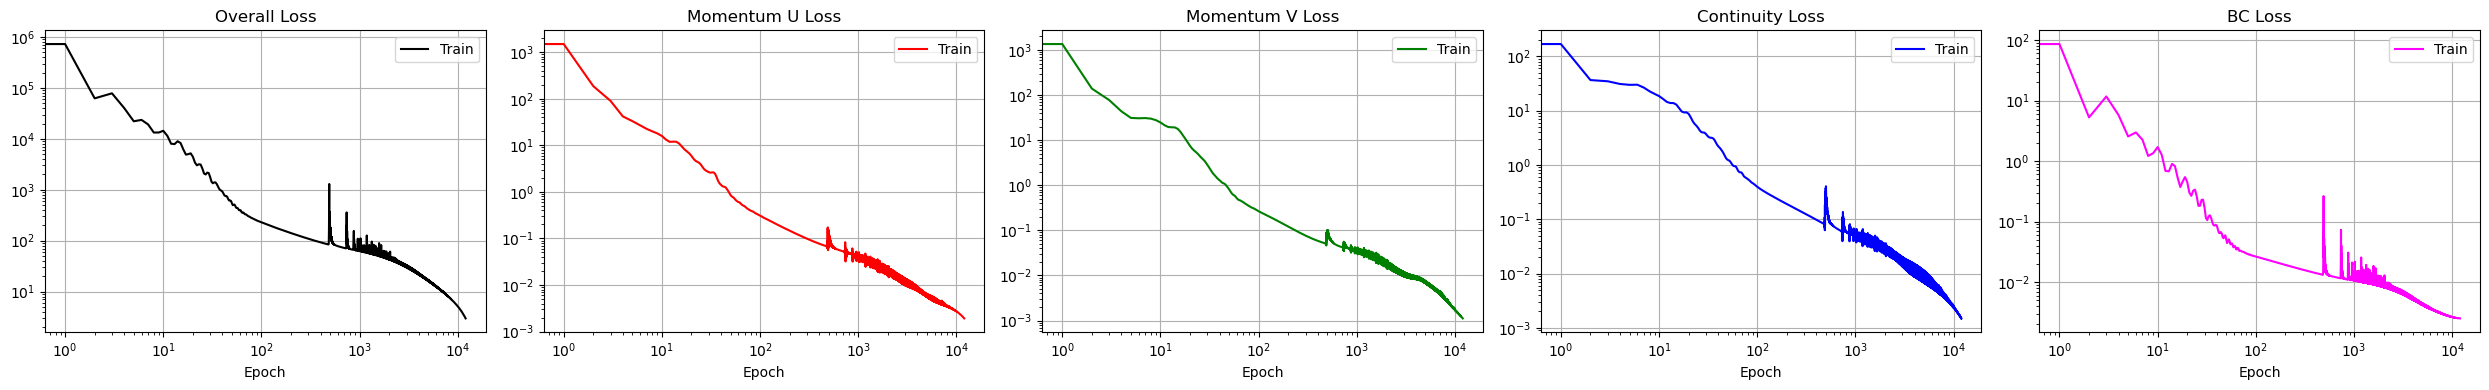

In [12]:
# Crear gráficos de pérdidas
loss_train_list = [loss_train, loss_train_momentum_u, loss_train_momentum_v, loss_train_continuity, loss_train_bc]
colors = ['black', 'red', 'green', 'blue', 'magenta']
titles = ['Overall Loss', 'Momentum U Loss', 'Momentum V Loss', 'Continuity Loss', 'BC Loss']

fig, ax = plt.subplots(1, len(loss_train_list), figsize=(25, 4))
for i in range(len(loss_train_list)):
    epochs_train = np.arange(0, len(loss_train_list[i]))
    ax[i].loglog(epochs_train, loss_train_list[i], color=colors[i], label='Train')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(titles[i])
    ax[i].legend()
    ax[i].grid(True)
plt.tight_layout()
plt.show()

### Predicciones en la malla de referencia

In [13]:
print("Realizando predicción en la malla de referencia...")

# Predicción del modelo en los puntos de referencia
with torch.no_grad():
    uvp_pred = model(X_ref)

# Separar componentes predichas y reshape
u_pred = uvp_pred[:, 0].reshape(nx, ny)
v_pred = uvp_pred[:, 1].reshape(nx, ny)
p_pred = uvp_pred[:, 2].reshape(nx, ny)

# Convertir a numpy para cálculos y visualización
u_pred_np = u_pred.cpu().numpy()
v_pred_np = v_pred.cpu().numpy()
p_pred_np = p_pred.cpu().numpy()

u_ref_np = u_tensor.cpu().numpy()
v_ref_np = v_tensor.cpu().numpy()
p_ref_np = p_tensor.cpu().numpy()

print("Predicción completada")

Realizando predicción en la malla de referencia...
Predicción completada


### Cálculo de norma-2 de errores


In [14]:
# Calcular errores absolutos
error_u = np.abs(u_pred_np - u_ref_np)
error_v = np.abs(v_pred_np - v_ref_np)
error_p = np.abs(p_pred_np - p_ref_np)

# Calcular normas-2 de los errores
norm2_error_u = np.linalg.norm(error_u)
norm2_error_v = np.linalg.norm(error_v)
norm2_error_p = np.linalg.norm(error_p)

# Calcular normas-2 de las soluciones de referencia para error relativo
norm2_ref_u = np.linalg.norm(u_ref_np)
norm2_ref_v = np.linalg.norm(v_ref_np)
norm2_ref_p = np.linalg.norm(p_ref_np)

# Errores relativos
rel_error_u = norm2_error_u / norm2_ref_u * 100
rel_error_v = norm2_error_v / norm2_ref_v * 100
rel_error_p = norm2_error_p / norm2_ref_p * 100

print("=== ANÁLISIS DE ERRORES (NORMA-2) ===")
print(f"Norma-2 del error absoluto:")
print(f"  - Velocidad u: {norm2_error_u:.6e}")
print(f"  - Velocidad v: {norm2_error_v:.6e}")
print(f"  - Presión p:   {norm2_error_p:.6e}")
print(f"\nError relativo (%):")
print(f"  - Velocidad u: {rel_error_u:.2f}%")
print(f"  - Velocidad v: {rel_error_v:.2f}%")
print(f"  - Presión p:   {rel_error_p:.2f}%")

=== ANÁLISIS DE ERRORES (NORMA-2) ===
Norma-2 del error absoluto:
  - Velocidad u: 4.418026e+03
  - Velocidad v: 2.992621e+03
  - Presión p:   8.839854e+03

Error relativo (%):
  - Velocidad u: 14204.15%
  - Velocidad v: 14205.57%
  - Presión p:   59109.31%


### Gráficos de error absoluto

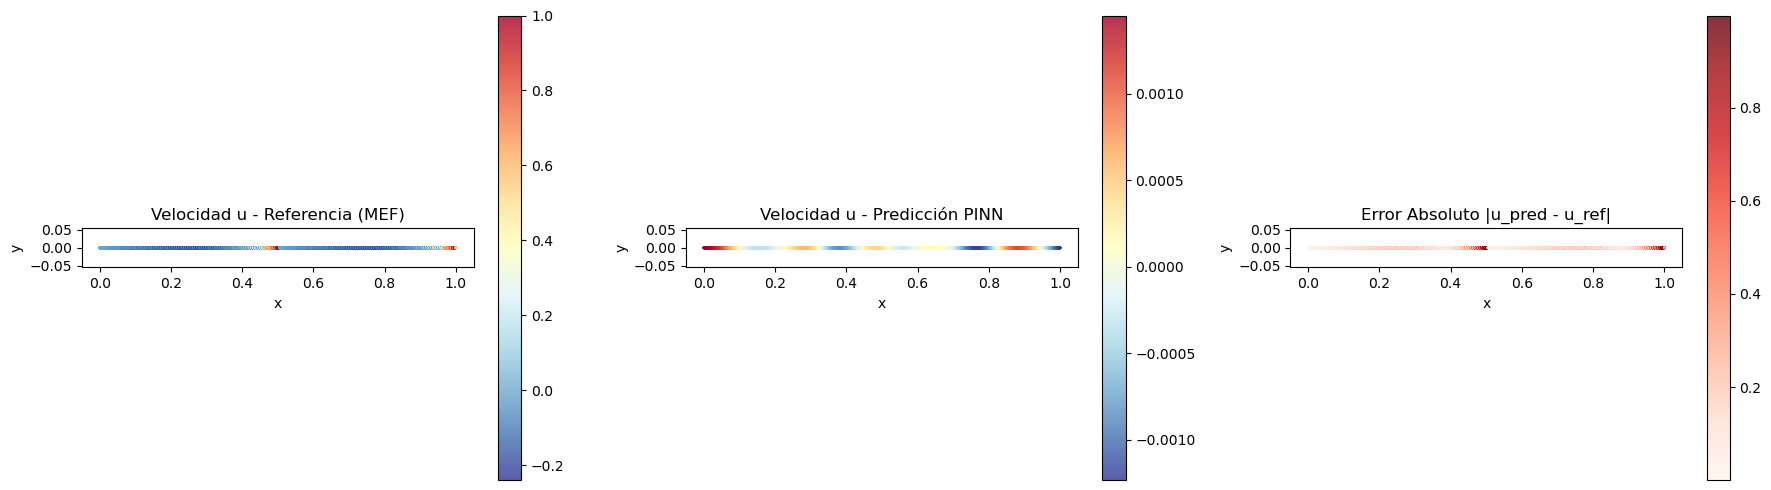

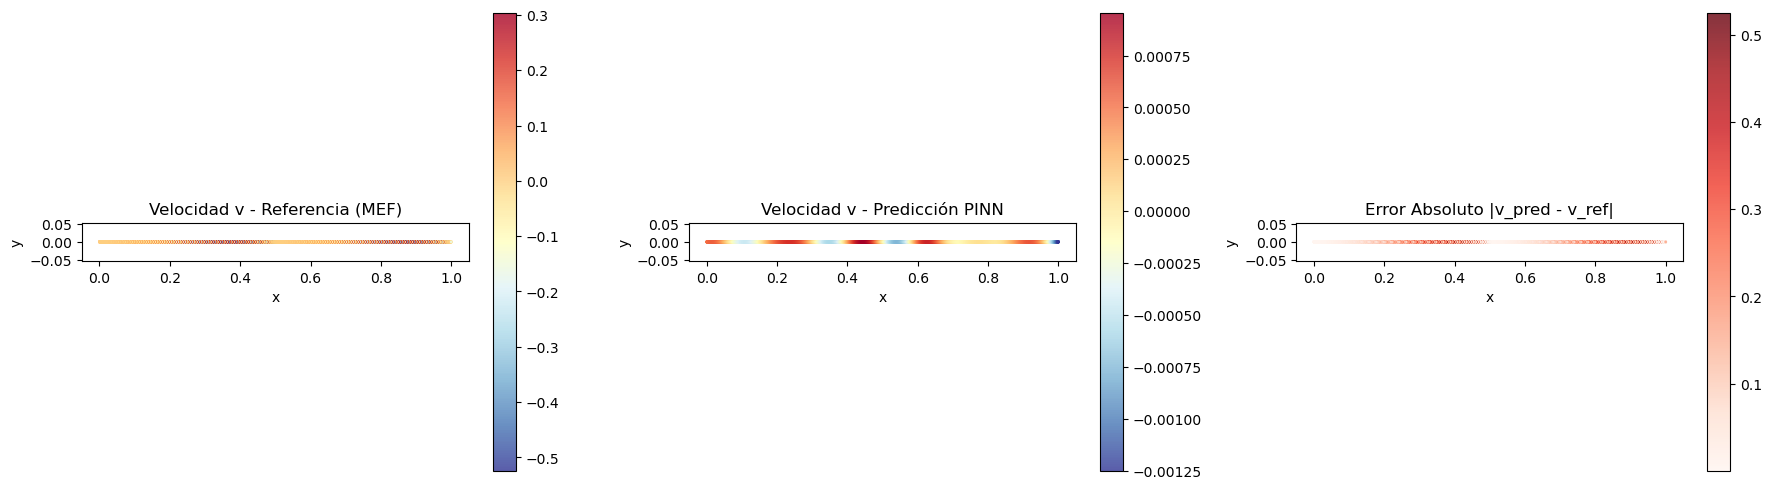

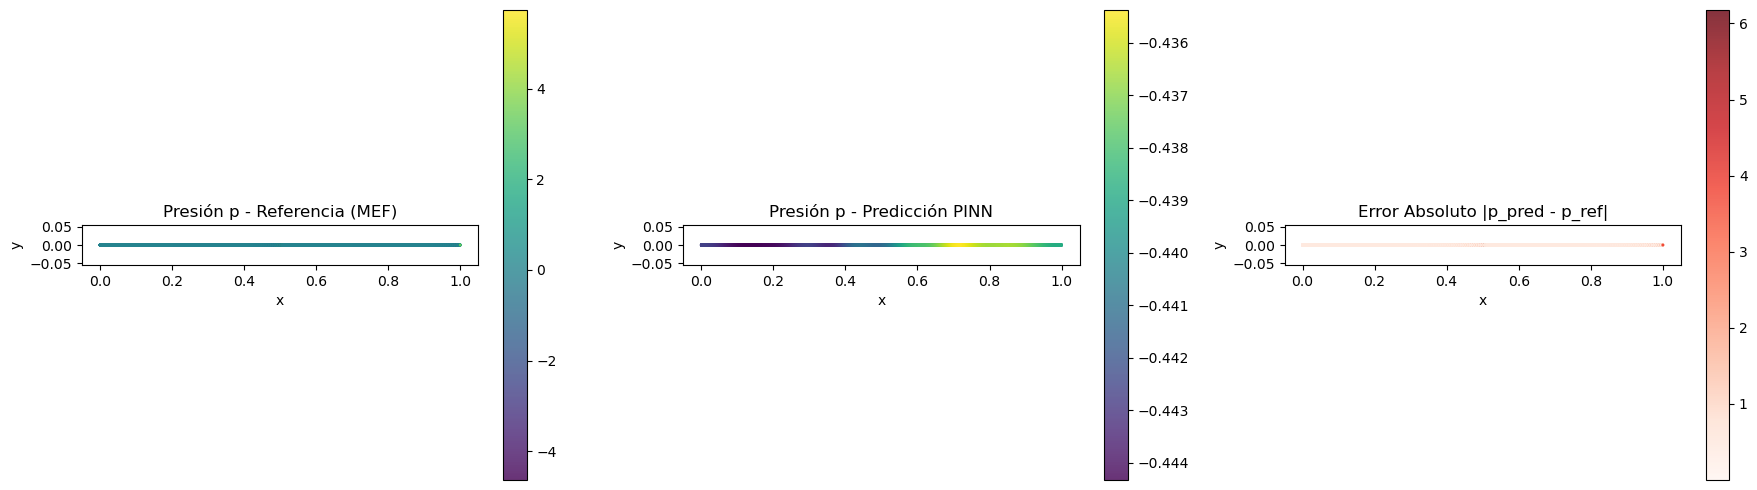

In [15]:
# Crear grilla para visualización
x_plot = np.linspace(xi, xf, nx)
y_plot = np.linspace(yi, yf, ny)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)

# Figura 1: Comparación de velocidades u
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Velocidad u - Referencia
im1 = axs[0].scatter(X_plot.flatten(), Y_plot.flatten(), c=u_ref_np.flatten(), 
                     cmap='RdYlBu_r', s=1, alpha=0.8)
axs[0].set_title('Velocidad u - Referencia (MEF)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')
plt.colorbar(im1, ax=axs[0])

# Velocidad u - Predicción PINN
im2 = axs[1].scatter(X_plot.flatten(), Y_plot.flatten(), c=u_pred_np.flatten(), 
                     cmap='RdYlBu_r', s=1, alpha=0.8)
axs[1].set_title('Velocidad u - Predicción PINN')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_aspect('equal')
plt.colorbar(im2, ax=axs[1])

# Error absoluto velocidad u
im3 = axs[2].scatter(X_plot.flatten(), Y_plot.flatten(), c=error_u.flatten()[:X_plot.size], 
                     cmap='Reds', s=1, alpha=0.8)
axs[2].set_title('Error Absoluto |u_pred - u_ref|')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_aspect('equal')
plt.colorbar(im3, ax=axs[2])

plt.tight_layout()
plt.savefig('./graficas/comparacion_velocidad_u.png')  # Guardar figura 1
plt.show()

# Figura 2: Comparación de velocidades v
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Velocidad v - Referencia
im1 = axs[0].scatter(X_plot.flatten(), Y_plot.flatten(), c=v_ref_np.flatten(), 
                     cmap='RdYlBu_r', s=1, alpha=0.8)
axs[0].set_title('Velocidad v - Referencia (MEF)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')
plt.colorbar(im1, ax=axs[0])

# Velocidad v - Predicción PINN
im2 = axs[1].scatter(X_plot.flatten(), Y_plot.flatten(), c=v_pred_np.flatten(), 
                     cmap='RdYlBu_r', s=1, alpha=0.8)
axs[1].set_title('Velocidad v - Predicción PINN')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_aspect('equal')
plt.colorbar(im2, ax=axs[1])

# Error absoluto velocidad v
im3 = axs[2].scatter(X_plot.flatten(), Y_plot.flatten(), c=error_v.flatten()[:X_plot.size], 
                     cmap='Reds', s=1, alpha=0.8)
axs[2].set_title('Error Absoluto |v_pred - v_ref|')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_aspect('equal')
plt.colorbar(im3, ax=axs[2])

plt.tight_layout()
plt.savefig('./graficas/comparacion_velocidad_v.png')  # Guardar figura 2
plt.show()

# Figura 3: Comparación de presión
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Presión - Referencia
im1 = axs[0].scatter(X_plot.flatten(), Y_plot.flatten(), c=p_ref_np.flatten(), 
                     cmap='viridis', s=1, alpha=0.8)
axs[0].set_title('Presión p - Referencia (MEF)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')
plt.colorbar(im1, ax=axs[0])

# Presión - Predicción PINN
im2 = axs[1].scatter(X_plot.flatten(), Y_plot.flatten(), c=p_pred_np.flatten(), 
                     cmap='viridis', s=1, alpha=0.8)
axs[1].set_title('Presión p - Predicción PINN')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_aspect('equal')
plt.colorbar(im2, ax=axs[1])

# Error absoluto presión
im3 = axs[2].scatter(X_plot.flatten(), Y_plot.flatten(), c=error_p.flatten()[:X_plot.size], 
                     cmap='Reds', s=1, alpha=0.8)
axs[2].set_title('Error Absoluto |p_pred - p_ref|')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_aspect('equal')
plt.colorbar(im3, ax=axs[2])

plt.tight_layout()
plt.savefig('./graficas/comparacion_presion.png')  # Guardar figura 3
plt.show()

### Análisis de perfiles en líneas características

Grid size aproximado: 142
Usando grilla 142×142 = 20164 puntos
✓ Datos convertidos a formato 2D: 142×142
Índices centrales: x=71, y=71


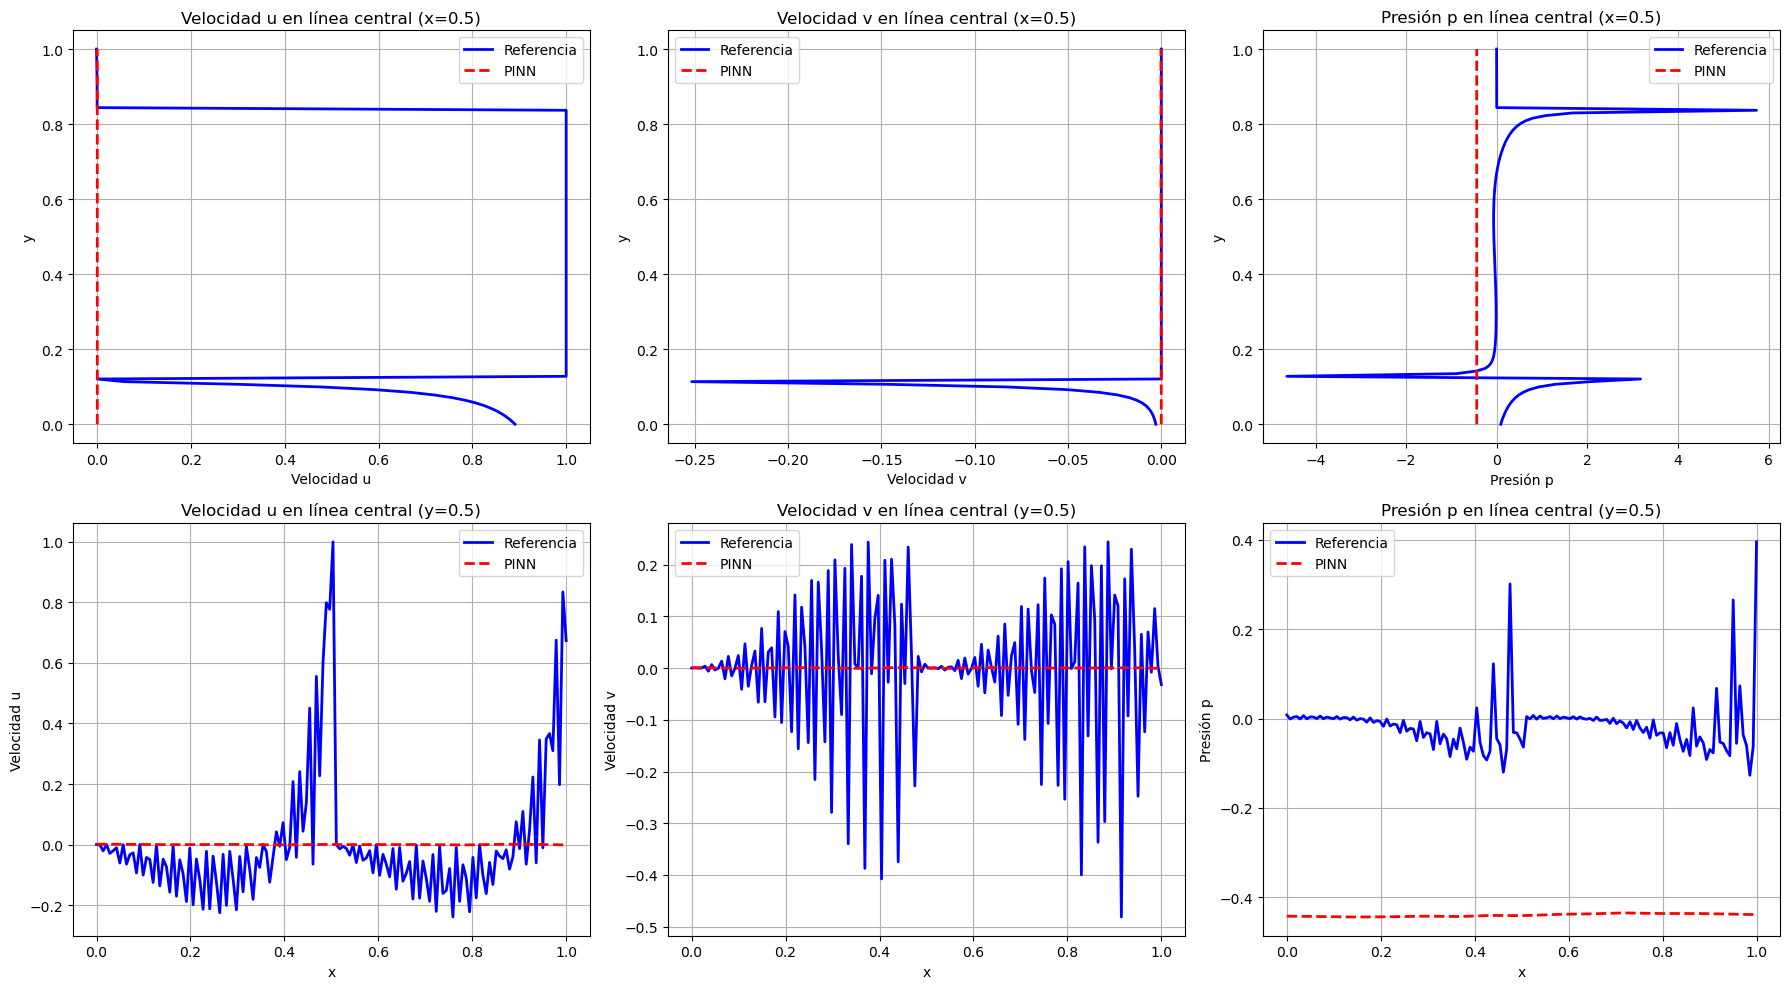

✓ Gráficos de perfiles en líneas características generados exitosamente


In [17]:
# Determinar dimensiones de grilla
total_points = 20201
# 20201 no es cuadrado perfecto, buscamos factores cercanos
grid_size = int(np.sqrt(total_points))  # 142
print(f"Grid size aproximado: {grid_size}")

# Buscar las mejores dimensiones rectangulares
best_nx, best_ny = 141, 143  # 141×143 = 20163 (muy cerca)
# O usar 142×142 = 20164 (también muy cerca)

# Usar aproximación cuadrada: 142×142 = 20164
nx_grid = ny_grid = 142
points_to_use = nx_grid * ny_grid  # 20164

print(f"Usando grilla {nx_grid}×{ny_grid} = {points_to_use} puntos")

# Convertir datos a formato consistente y luego a 2D
# Referencia: (1, 20201) → extraer primeros 20164 → reshape(142, 142)
u_ref_flat = u_ref_np[0, :points_to_use]  # Tomar primeros 20164 puntos
v_ref_flat = v_ref_np[0, :points_to_use] 
p_ref_flat = p_ref_np[0, :points_to_use]

# Predicción: (20201, 1) → extraer primeros 20164 → reshape(142, 142)  
u_pred_flat = u_pred_np[:points_to_use, 0]  # Tomar primeros 20164 puntos
v_pred_flat = v_pred_np[:points_to_use, 0]
p_pred_flat = p_pred_np[:points_to_use, 0]

# Convertir a formato 2D
u_ref_2d = u_ref_flat.reshape(nx_grid, ny_grid)
v_ref_2d = v_ref_flat.reshape(nx_grid, ny_grid)
p_ref_2d = p_ref_flat.reshape(nx_grid, ny_grid)

u_pred_2d = u_pred_flat.reshape(nx_grid, ny_grid)
v_pred_2d = v_pred_flat.reshape(nx_grid, ny_grid)
p_pred_2d = p_pred_flat.reshape(nx_grid, ny_grid)

print(f"✓ Datos convertidos a formato 2D: {nx_grid}×{ny_grid}")

# Crear líneas para gráficos
x_line = np.linspace(0, 1, nx_grid)
y_line = np.linspace(0, 1, ny_grid)

# Índices centrales
x_center_idx = nx_grid // 2  # 71
y_center_idx = ny_grid // 2  # 71

print(f"Índices centrales: x={x_center_idx}, y={y_center_idx}")

# Generar gráficos
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# FILA SUPERIOR: Líneas verticales (x fijo = 0.5, y variable)
# Velocidad u en línea central vertical
axs[0, 0].plot(u_ref_2d[x_center_idx, :], y_line, 'b-', linewidth=2, label='Referencia')
axs[0, 0].plot(u_pred_2d[x_center_idx, :], y_line, 'r--', linewidth=2, label='PINN')
axs[0, 0].set_xlabel('Velocidad u')
axs[0, 0].set_ylabel('y')
axs[0, 0].set_title('Velocidad u en línea central (x=0.5)')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Velocidad v en línea central vertical
axs[0, 1].plot(v_ref_2d[x_center_idx, :], y_line, 'b-', linewidth=2, label='Referencia')
axs[0, 1].plot(v_pred_2d[x_center_idx, :], y_line, 'r--', linewidth=2, label='PINN')
axs[0, 1].set_xlabel('Velocidad v')
axs[0, 1].set_ylabel('y')
axs[0, 1].set_title('Velocidad v en línea central (x=0.5)')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Presión en línea central vertical
axs[0, 2].plot(p_ref_2d[x_center_idx, :], y_line, 'b-', linewidth=2, label='Referencia')
axs[0, 2].plot(p_pred_2d[x_center_idx, :], y_line, 'r--', linewidth=2, label='PINN')
axs[0, 2].set_xlabel('Presión p')
axs[0, 2].set_ylabel('y')
axs[0, 2].set_title('Presión p en línea central (x=0.5)')
axs[0, 2].legend()
axs[0, 2].grid(True)

# FILA INFERIOR: Líneas horizontales (y fijo = 0.5, x variable)
# Velocidad u en línea central horizontal
axs[1, 0].plot(x_line, u_ref_2d[:, y_center_idx], 'b-', linewidth=2, label='Referencia')
axs[1, 0].plot(x_line, u_pred_2d[:, y_center_idx], 'r--', linewidth=2, label='PINN')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('Velocidad u')
axs[1, 0].set_title('Velocidad u en línea central (y=0.5)')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Velocidad v en línea central horizontal
axs[1, 1].plot(x_line, v_ref_2d[:, y_center_idx], 'b-', linewidth=2, label='Referencia')
axs[1, 1].plot(x_line, v_pred_2d[:, y_center_idx], 'r--', linewidth=2, label='PINN')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('Velocidad v')
axs[1, 1].set_title('Velocidad v en línea central (y=0.5)')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Presión en línea central horizontal
axs[1, 2].plot(x_line, p_ref_2d[:, y_center_idx], 'b-', linewidth=2, label='Referencia')
axs[1, 2].plot(x_line, p_pred_2d[:, y_center_idx], 'r--', linewidth=2, label='PINN')
axs[1, 2].set_xlabel('x')
axs[1, 2].set_ylabel('Presión p')
axs[1, 2].set_title('Presión p en línea central (y=0.5)')
axs[1, 2].legend()
axs[1, 2].grid(True)

plt.tight_layout()
plt.savefig('./graficas/perfiles_lineas_caracteristicas.png')
plt.show()

print("✓ Gráficos de perfiles en líneas características generados exitosamente")

### Evaluación y análisis del modelo desarrollado


In [18]:
print("=== EVALUACIÓN DEL MODELO PINN DESARROLLADO ===")
print("\n1. GRADO DE CONVERGENCIA DURANTE EL ENTRENAMIENTO:")
final_loss = loss_train[-1]
initial_loss = loss_train[0]
reduction_factor = initial_loss / final_loss

print(f"   - Pérdida inicial: {initial_loss:.6e}")
print(f"   - Pérdida final: {final_loss:.6e}")
print(f"   - Factor de reducción: {reduction_factor:.2f}x")

# Verificar convergencia en las últimas épocas
if len(loss_train) > 100:
    last_100_std = np.std(loss_train[-100:])
    last_100_mean = np.mean(loss_train[-100:])
    cv = last_100_std / last_100_mean * 100
    print(f"   - Coeficiente de variación (últimas 100 épocas): {cv:.2f}%")
    
    if cv < 5:
        convergence_status = "✓ BUENA - El modelo muestra convergencia estable"
    else:
        convergence_status = "⚠ MODERADA - El modelo podría necesitar más épocas"
else:
    convergence_status = "⚠ INSUFICIENTE - Muy pocas épocas para evaluar"

print(f"   - Estado de convergencia: {convergence_status}")

print("\n2. PRECISIÓN DE PREDICCIÓN DE CAMPOS:")
print(f"   - Error relativo velocidad u: {rel_error_u:.2f}%")
print(f"   - Error relativo velocidad v: {rel_error_v:.2f}%")
print(f"   - Error relativo presión p: {rel_error_p:.2f}%")

# Clasificación de la precisión
if rel_error_u < 5 and rel_error_v < 5 and rel_error_p < 10:
    precision_level = "EXCELENTE"
    precision_color = "✓"
elif rel_error_u < 10 and rel_error_v < 10 and rel_error_p < 20:
    precision_level = "BUENA"
    precision_color = "✓"
elif rel_error_u < 20 and rel_error_v < 20 and rel_error_p < 30:
    precision_level = "ACEPTABLE"
    precision_color = "~"
else:
    precision_level = "NECESITA MEJORAS"
    precision_color = "⚠"

print(f"   - Clasificación de precisión: {precision_color} {precision_level}")

print("\n3. FALLAS OBSERVADAS:")

if final_loss > 1e-4:
    print("   ⚠ La función de pérdida final es relativamente alta")
    print("     - Podría indicar falta de convergencia completa")

if rel_error_p > 15:
    print("   ⚠ Error en presión superior al esperado")
    print("     - La presión es más difícil de capturar que las velocidades")

if cv > 10:
    print("   ⚠ Inestabilidad en las últimas épocas de entrenamiento")
    print("     - El learning rate podría ser demasiado alto")

# Verificar conservación de masa
X_test = torch.rand(1000, 2, device=device)
X_test.requires_grad = True
uvp_test = model(X_test)
_, _, residue_cont_test = model.navierstokesResidue(X_test, uvp_test)
avg_continuity_residue = torch.mean(torch.abs(residue_cont_test)).item()

if avg_continuity_residue > 1e-2:
    print(f"   ⚠ Violación de conservación de masa (residuo: {avg_continuity_residue:.4e})")

# Verificar condiciones de borde
u_top_center = u_pred_np[nx//2, -1]
u_bottom_center = u_pred_np[nx//2, 0]
v_left_center = v_pred_np[0, ny//2]

if abs(u_top_center - 1.0) > 0.1:
    print(f"   ⚠ Condición de borde superior mal satisfecha (u={u_top_center:.3f}, esperado=1.0)")

if abs(u_bottom_center) > 0.05:
    print(f"   ⚠ Condición no-slip inferior mal satisfecha (u={u_bottom_center:.3f}, esperado=0.0)")

print("\n4. ASPECTOS POSITIVOS DESTACADOS:")

if reduction_factor > 100:
    print("   ✓ Excelente reducción de la función de pérdida durante entrenamiento")

if rel_error_u < 15 and rel_error_v < 15:
    print("   ✓ Buena captura de los campos de velocidad")

if avg_continuity_residue < 1e-2:
    print(f"   ✓ Buena conservación de masa (residuo: {avg_continuity_residue:.4e})")

if abs(u_top_center - 1.0) < 0.05:
    print("   ✓ Correcta implementación de condición lid-driven")

if cv < 5:
    print("   ✓ Entrenamiento estable y bien convergido")

print("\n5. CONSIDERACIÓN SOBRE HIPERPARÁMETROS:")

print(f"   - Learning rate actual: {optimizer.param_groups[0]['lr']}")
print(f"   - Arquitectura: {model_parameters['NumberOfHiddenLayers']} capas, {model_parameters['NumberOfNeurons']} neuronas")
print(f"   - Épocas de entrenamiento: {epochs}")

if final_loss > 1e-4:
    print("   → Los hiperparámetros podrían optimizarse:")
    print("     • Reducir learning rate para mejor convergencia fina")
    print("     • Aumentar número de épocas")

if rel_error_p > 20:
    print("   → Para mejorar la presión:")
    print("     • Aumentar el peso de las pérdidas PDE")
    print("     • Incrementar profundidad de la red")

print("\n6. ACCIONES DE MEJORA RECOMENDADAS:")

if precision_level in ["NECESITA MEJORAS", "ACEPTABLE"]:
    print("   • Arquitectura de red:")
    print("     - Aumentar número de capas ocultas (10-12)")
    print("     - Incrementar neuronas por capa (100-200)")
    print("   • Estrategia de entrenamiento:")
    print("     - Implementar learning rate scheduling")
    print("     - Usar optimizador L-BFGS en etapas finales")
    print("     - Aumentar epochs a 10000-15000")
    print("   • Puntos de colocación:")
    print("     - Usar muestreo adaptativo cerca de regiones críticas")
    print("     - Incrementar densidad de puntos en bordes")

if avg_continuity_residue > 1e-3:
    print("   • Para mejor conservación de masa:")
    print("     - Aumentar peso de la pérdida de continuidad")
    print("     - Implementar normalización divergence-free")

print("\n=== CONCLUSIÓN GENERAL ===")
if precision_level in ["EXCELENTE", "BUENA"]:
    print("El modelo PINN desarrollado demuestra capacidad satisfactoria para")
    print("resolver las ecuaciones de Navier-Stokes en la configuración de")
    print("cavidad cuadrada, capturando adecuadamente la física del problema.")
else:
    print("El modelo PINN muestra potencial pero requiere optimizaciones")
    print("adicionales en arquitectura e hiperparámetros para alcanzar")
    print("precisión competitiva con métodos tradicionales.")

print(f"\nEl modelo puede considerarse '{precision_level}' para este problema.")
print(f"Tiempo total de procesamiento: {elapsed_time_train.total_seconds():.2f} segundos")


=== EVALUACIÓN DEL MODELO PINN DESARROLLADO ===

1. GRADO DE CONVERGENCIA DURANTE EL ENTRENAMIENTO:
   - Pérdida inicial: 7.970916e+04
   - Pérdida final: 2.974866e+00
   - Factor de reducción: 26794.20x
   - Coeficiente de variación (últimas 100 épocas): 0.93%
   - Estado de convergencia: ✓ BUENA - El modelo muestra convergencia estable

2. PRECISIÓN DE PREDICCIÓN DE CAMPOS:
   - Error relativo velocidad u: 14204.15%
   - Error relativo velocidad v: 14205.57%
   - Error relativo presión p: 59109.31%
   - Clasificación de precisión: ⚠ NECESITA MEJORAS

3. FALLAS OBSERVADAS:
   ⚠ La función de pérdida final es relativamente alta
     - Podría indicar falta de convergencia completa
   ⚠ Error en presión superior al esperado
     - La presión es más difícil de capturar que las velocidades
   ⚠ Violación de conservación de masa (residuo: 2.6427e-02)
   ⚠ Condición de borde superior mal satisfecha (u=0.000, esperado=1.0)

4. ASPECTOS POSITIVOS DESTACADOS:
   ✓ Excelente reducción de la func